# Importing all useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import product
from tqdm import tqdm

# from sklearn model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_predict

# ML models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [2]:
test = pd.read_csv('dataset/test.csv')
train = pd.read_csv('dataset/train.csv')
features = pd.read_csv('dataset/features.csv')
stores = pd.read_csv('dataset/stores.csv')
sampleSubmission = pd.read_csv('dataset/sampleSubmission.csv')

# 1 - Analysing the datasets: EDA

We are going to do an Exploratory Data Analysis on all the datasets, to see what we can remove that is not useful to train the model.

In [3]:
print('test:', len(test), test.columns)
print('train:', len(train), train.columns)
print('features:', len(features), features.columns)
print('stores:', len(stores), stores.columns)

test: 115064 Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')
train: 421570 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
features: 8190 Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')
stores: 45 Index(['Store', 'Type', 'Size'], dtype='object')


In [4]:
print(train.dtypes)
train.head(10)

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


We can see that the `Date` type is `object`, so we need to convert it to `datetime`.

In [5]:
test['Date'] = pd.to_datetime(test['Date'])
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])


In [6]:
print('test\n', test.dtypes)
print('\ntrain\n', train.dtypes)
print('\nfeatures\n', features.dtypes)

test
 Store                 int64
Dept                  int64
Date         datetime64[ns]
IsHoliday              bool
dtype: object

train
 Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

features
 Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
dtype: object


## 1.1 - Merging
Now we can merge the datasets; we will merge first features and stores together, and then merge them to the train and the test sets.

In [7]:
df_train_orig = train.merge(features, how='left').merge(stores, how='left')

In [9]:
df_train_orig.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [10]:
df_train_orig.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [11]:
df_test_orig = test.merge(features, how='left').merge(stores, how='left')

In [12]:
df_test_orig.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315


## 1.2 - Correlation
We check the null values inside the dataframe and eventually drop those columns, because they could be just a dead weight.

In [13]:
df_train_orig.isnull().mean() * 100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64

As we can see, the columns with none values are: `MarkDown1`, `MarkDown2`, `MarkDown3`, `MarkDown4` and `MarkDown5`. So we decided to drop them both in train and test sets.

In [14]:
df_train = df_train_orig.copy()
df_test = df_test_orig.copy()

In [15]:
df_train.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

In [16]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [17]:
df_test.isnull().mean() * 100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1        0.129493
MarkDown2       24.879198
MarkDown3        8.542203
MarkDown4       11.200723
MarkDown5        0.000000
CPI             33.165890
Unemployment    33.165890
Type             0.000000
Size             0.000000
dtype: float64

In [18]:
df_test.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

In [19]:
df_test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,223.610984,6.573,A,151315


We also build a correlation matrix to see what are the features less correlated to `Weekly_Sales`.

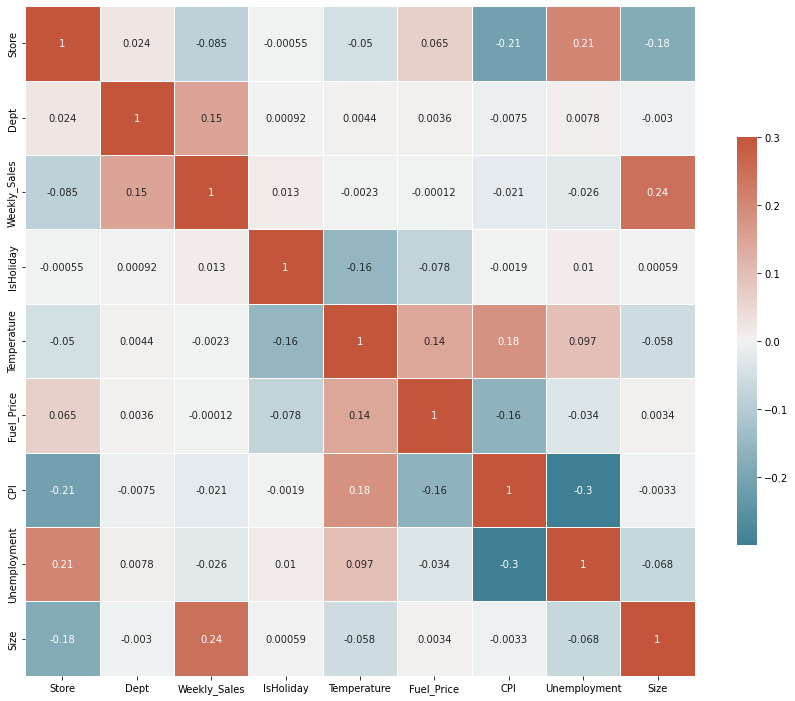

In [20]:
corr = df_train.corr()
f, ax = plt.subplots(figsize=(15, 15), facecolor='white')
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

As a result, the less correlated features to `Weekly_Sales` are `Temperature`, `Fuel_Price`, `CPI` and `Unemployment`, so we decided to drop those columns.

In [21]:
df_train.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1, inplace=True)

In [22]:
df_test.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1, inplace=True)

## 1.3 - Observation

After the Correlation part, we wanted to have a visualization of our data, so we labeled the Holiday types with the respective dates below, and then we plotted the `Weekly_Sales` trend of the train set.

| Label | Holiday type | Dates |
| --- | --- | --- |
| 0 | NONE | NONE |
| 1 | Super Bowl | 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13 |
| 2 | Labor Day | 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13 |
| 3 | Thanksgiving | 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13 |
| 4 | Christmas | 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13 |

Here we label the Holidays and we add `week`, `year` and `month` features for every instance of the train and test sets, useful to plot the `Weekly_Sales` trend. We then also changed all the columns to `float64` types, and changed the `Type` column values from `A, B, C` to respectively `1, 2, 3`.

We altered a bit the functions we took from the code of [Mariana Dehon](https://www.kaggle.com/marianadehon/walmart-store-sales-forecasting) on Kaggle.

In [23]:
def create_holiday_type_column(df, dates, holiday_type):
    df.loc[
        df['Date'].isin(dates),
        'HolidayType'
    ] = holiday_type

def create_features(df):
    """
    This function creates the following features: Week, Month, Year and
    HolidayType. HolidayType values are the following:
    0 = No holiday
    1 = SuperBowl
    2 = LaborDay
    3 = Thanksgiving
    4 = Christmas
    """

    df['HolidayType'] = 0

    holiday_list = [
        (['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'], 'Super_Bowl'),
        (['2010-09-10','2011-09-09', '2012-09-07', '2013-09-06'], 'Labor_Day'),
        (['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'], 'Thanksgiving'),
        (['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'], 'Christmas')
    ]

    for index in range(0, len(holiday_list)):
        holiday = holiday_list[index]
        create_holiday_type_column(df, holiday[0], index+1)

    df['Week'] = df.Date.dt.isocalendar().week.astype('float64')
    df['Year'] =  df.Date.dt.isocalendar().year.astype('float64')
    df['Month'] =  df.Date.dt.month.astype('float64')
    df.Type = df.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
    # Convert all columns to float
    for x in df:
        df[x] = df[x].fillna(0)
        if df[x].dtypes == "int64":
            df[x] = df[x].astype(float)



In [24]:
create_features(df_train)

In this cell we compute the `Weekly_Sales` trend plot.

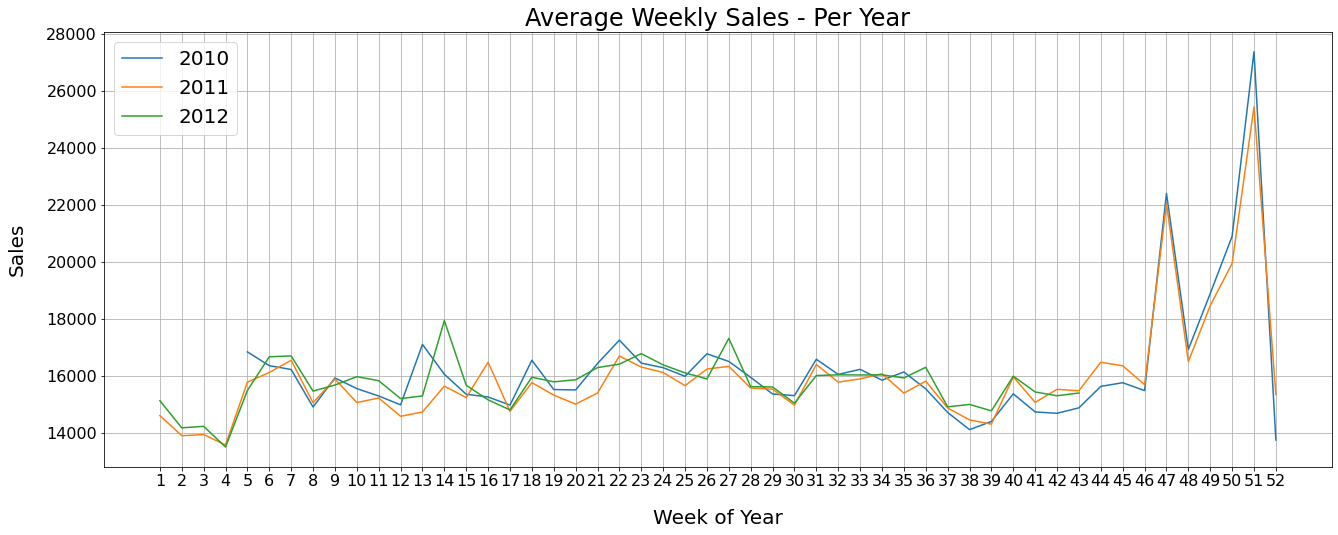

In [26]:
weekly_sales_2010 = df_train[df_train.Year==2010].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2011 = df_train[df_train.Year==2011].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2012 = df_train[df_train.Year==2012].groupby('Week')['Weekly_Sales'].mean()

plt.figure(figsize=(22,8), facecolor='white')
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values)
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values)
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Week of Year', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20)

plt.title("Average Weekly Sales - Per Year", fontsize=24)
plt.legend(['2010', '2011', '2012'], fontsize=20)
plt.show()

We can notice that there are peaks in correspondence of Easter, Thanksgiving and Christmas holidays, so we expect to have the same results for the test set, after the prediction.

In [29]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,HolidayType,Week,Year,Month
0,1.0,1.0,2010-02-05,24924.50,False,3.0,151315.0,0.0,5.0,2010.0,2.0
1,1.0,1.0,2010-02-12,46039.49,True,3.0,151315.0,1.0,6.0,2010.0,2.0
2,1.0,1.0,2010-02-19,41595.55,False,3.0,151315.0,0.0,7.0,2010.0,2.0
3,1.0,1.0,2010-02-26,19403.54,False,3.0,151315.0,0.0,8.0,2010.0,2.0
4,1.0,1.0,2010-03-05,21827.90,False,3.0,151315.0,0.0,9.0,2010.0,3.0


# 2 - Training the model

In this section, we are going to find the best regressor model to use for the prediction, and then we will tune the best hyperparameters to use.

In [25]:
def WMAE(dataset, real, predicted):
    """
    Implementation of competition evaluation metric
    """
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 5)

## 2.1 - Find the best model

Split the train set into X and y (`Weekly_Sales`)

In [31]:
y = df_train['Weekly_Sales']

In [32]:
print(df_train.columns.tolist())

['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size', 'HolidayType', 'Week', 'Year', 'Month']


In [33]:
X = df_train[['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'HolidayType', 'Week', 'Year', 'Month']]

In [36]:
# check that all the columns are numerics
categorical_features = X.columns[X.dtypes == 'O']
numeric_features = X.columns[X.dtypes == 'float64' ]
for col in X.columns:
    if col in categorical_features:
        print('{} is categorical'.format(col))
    else:
        print('{} is numerical'.format(col))

Store is numerical
Dept is numerical
IsHoliday is numerical
Type is numerical
Size is numerical
HolidayType is numerical
Week is numerical
Year is numerical
Month is numerical


We took the function below from the code of [Mariana Dehon](https://www.kaggle.com/marianadehon/walmart-store-sales-forecasting) on Kaggle.

In [37]:
def plot_regression_results(y_true, y_pred, title, scores):
    """
    Scatter plot of the predicted vs true targets
    """
    ax = plt.gca()
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc='w', fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title
    ax.set_title(title)
    plt.show()

In [38]:
regression_models = [
    'LinearRegression',
    'KNN',
    'RandomForestRegressor',
    'AdaBoostRegressor'
]

best_model = None
best_error = math.inf

We altered a bit the two cells below from the code of [Mariana Dehon](https://www.kaggle.com/marianadehon/walmart-store-sales-forecasting) on Kaggle.

In [39]:
def model_factory(model_type, **kwargs):
    """
    This function creates a model considering the model_type
    and specific arguments.
    """

    # Specific for RandomForestRegressor or AdaBoostRegressor
    if model_type in ['RandomForestRegressor', 'AdaBoostRegressor']:
        n_estimators = kwargs.get('n_estimators')
        verbose = kwargs.get('verbose')
        n_jobs = kwargs.get('n_jobs')

        if n_estimators is None:
            n_estimators = 50

        verbose = 1 if verbose is None else verbose

    if model_type == 'LinearRegression':
        return LinearRegression()
    elif model_type == 'KNN':
        return KNeighborsRegressor()
    elif model_type == 'RandomForestRegressor':
        return RandomForestRegressor(
            n_estimators = n_estimators,
            verbose = verbose,
            n_jobs = n_jobs
        )
    elif model_type == 'AdaBoostRegressor':
        return AdaBoostRegressor(
            n_estimators = n_estimators
        )
    else:
        raise ValueError('Model not defined on factory.')

--------------------------------------------------
Training evaluation
--------------------------------------------------
:: LinearRegression - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


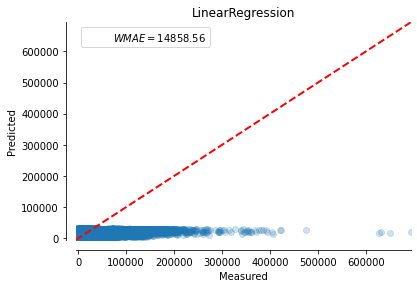

--------------------------------------------------
:: KNN - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


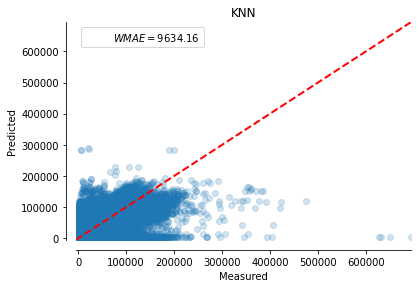

--------------------------------------------------
:: RandomForestRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   44.6s finished


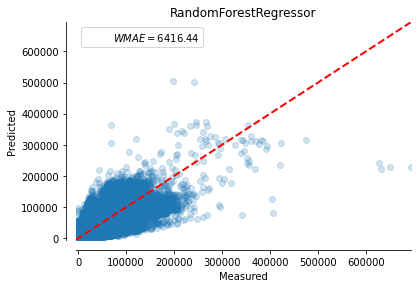

--------------------------------------------------
:: AdaBoostRegressor - Training Pipeline


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.3s finished


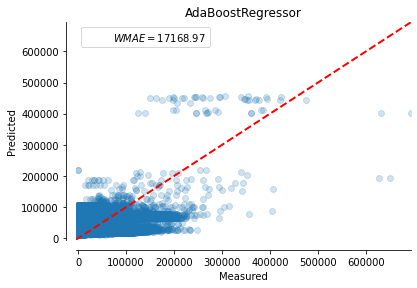

--------------------------------------------------


In [40]:


print('-' * 50)
print('Training evaluation')
print('-' * 50)

for name in regression_models:
    # Create a basic pipeline
    print(f':: {name} - Training Pipeline')
    regressor = model_factory(name)

    kfold = KFold(n_splits=10)

    y_pred = cross_val_predict(
        regressor,
        X,
        y,
        cv = kfold,
        n_jobs = -1,
        verbose = 1
    )

    wmae_metric = WMAE(X, y, y_pred)

    if wmae_metric < best_error:
        best_error = wmae_metric
        best_model = name

    plot_regression_results(
        y,
        y_pred,
        name,
        (r'$WMAE ={:.2f}$').format(wmae_metric)
    )

    print('-' * 50)

In [41]:
print(f'Best model is {best_model}')
print(f'Best score is {best_error}')

Best model is RandomForestRegressor
Best score is 6416.43537


## 2.2 - Tuning of the hyperparameters

In [42]:
# Create the random grid
random_grid = {
    'n_estimators': [x for x in range(45, 61, 5)],
    'max_depth': [15, 20, 25, 30],
    'min_samples_split': [2, 3, 4, 5]
}

random_grid

{'n_estimators': [45, 50, 55, 60],
 'max_depth': [15, 20, 25, 30],
 'min_samples_split': [2, 3, 4, 5]}

In [43]:
def get_best_model_parameters(random_grid, X, y):

    comb_params = list(product(random_grid['n_estimators'], random_grid['max_depth'], random_grid['min_samples_split']))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

    best_wmae = math.inf
    best_params = {}
    for comb in tqdm(comb_params):

        model_random = RandomForestRegressor(n_estimators=comb[0], max_depth=comb[1], min_samples_split=comb[2])
        model_random.fit(X_train, y_train)
        y_pred = model_random.predict(X_test)
        wmae_now = WMAE(X_test, y_test, y_pred)

        if wmae_now < best_wmae:
            best_wmae = wmae_now
            best_params = {'n_estimators':comb[0],
                           'max_depth':comb[1],
                           'min_samples_split':comb[2]}


    return best_wmae, best_params

# Best Parameter combination
best_wmae, best_params = get_best_model_parameters(random_grid, X, y)
best_params

100%|██████████| 64/64 [09:30<00:00,  8.92s/it]


{'n_estimators': 55, 'max_depth': 25, 'min_samples_split': 2}

In [44]:
print(f'Best model is {best_model}')
print(f'Best params are {best_params}')

model = model_factory(
    best_model,
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    max_depth=best_params['min_samples_split'],
    verbose=1,
    njobs=-1)

model.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model is RandomForestRegressor
Best params are {'n_estimators': 55, 'max_depth': 25, 'min_samples_split': 2}


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   38.5s finished


RandomForestRegressor(n_estimators=55, verbose=1)

In [45]:
X.columns.to_list()

['Store',
 'Dept',
 'IsHoliday',
 'Type',
 'Size',
 'HolidayType',
 'Week',
 'Year',
 'Month']

Now we need to set the test set as the same as the train one, but just with the `X`, since we need to predict the `y`.

In [46]:
create_features(df_test)

In [47]:
X_test = df_test[X.columns.to_list()]
X_test

,Store,Dept,IsHoliday,Type,Size,HolidayType,Week,Year,Month
0,1.0,1.0,False,3.0,151315.0,0.0,44.0,2012.0,11.0
1,1.0,1.0,False,3.0,151315.0,0.0,45.0,2012.0,11.0
2,1.0,1.0,False,3.0,151315.0,0.0,46.0,2012.0,11.0
3,1.0,1.0,True,3.0,151315.0,3.0,47.0,2012.0,11.0
4,1.0,1.0,False,3.0,151315.0,0.0,48.0,2012.0,11.0
...,...,...,...,...,...,...,...,...,...
115059,45.0,98.0,False,2.0,118221.0,0.0,26.0,2013.0,6.0
115060,45.0,98.0,False,2.0,118221.0,0.0,27.0,2013.0,7.0
115061,45.0,98.0,False,2.0,118221.0,0.0,28.0,2013.0,7.0
115062,45.0,98.0,False,2.0,118221.0,0.0,29.0,2013.0,7.0


In [48]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.6s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    2.1s finished


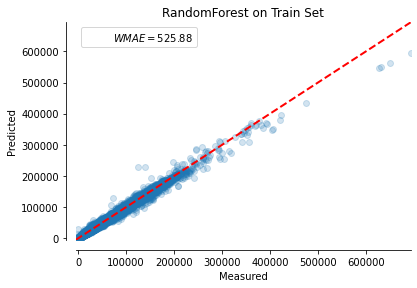

In [49]:
y_pred_train = model.predict(X)
plot_regression_results(
    y,
    y_pred_train,
    'RandomForest on Train Set',
    (r'$WMAE ={:.2f}$').format(WMAE(X, y, y_pred_train))
)

We altered a bit the function below from the code of [Mariana Dehon](https://www.kaggle.com/marianadehon/walmart-store-sales-forecasting) on Kaggle.

In [50]:
def graph_relation_to_weekly_sale(col_relation, df, x='Week', palette=None):
    """
    This function plots the graph relation between
    a categorized feature and the Weekly_Sales
    """
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    sns.relplot(
        x=x,
        y='Weekly_Sales',
        hue=col_relation,
        data=df,
        kind='line',
        height=5,
        aspect=2,
        palette=palette
    )
    plt.show()

In [51]:
df_test['Weekly_Sales'] = y_pred
df_test['DatasetType'] = 'Predicted'

df_train['DatasetType'] = 'Actual'

df_result = pd.concat([df_train, df_test]).reset_index(drop=True)
df_result

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,HolidayType,Week,Year,Month,DatasetType
0,1.0,1.0,2010-02-05,24924.500000,False,3.0,151315.0,0.0,5.0,2010.0,2.0,Actual
1,1.0,1.0,2010-02-12,46039.490000,True,3.0,151315.0,1.0,6.0,2010.0,2.0,Actual
2,1.0,1.0,2010-02-19,41595.550000,False,3.0,151315.0,0.0,7.0,2010.0,2.0,Actual
3,1.0,1.0,2010-02-26,19403.540000,False,3.0,151315.0,0.0,8.0,2010.0,2.0,Actual
4,1.0,1.0,2010-03-05,21827.900000,False,3.0,151315.0,0.0,9.0,2010.0,3.0,Actual
...,...,...,...,...,...,...,...,...,...,...,...,...
536629,45.0,98.0,2013-06-28,680.682909,False,2.0,118221.0,0.0,26.0,2013.0,6.0,Predicted
536630,45.0,98.0,2013-07-05,672.290909,False,2.0,118221.0,0.0,27.0,2013.0,7.0,Predicted
536631,45.0,98.0,2013-07-12,685.267818,False,2.0,118221.0,0.0,28.0,2013.0,7.0,Predicted
536632,45.0,98.0,2013-07-19,775.694727,False,2.0,118221.0,0.0,29.0,2013.0,7.0,Predicted


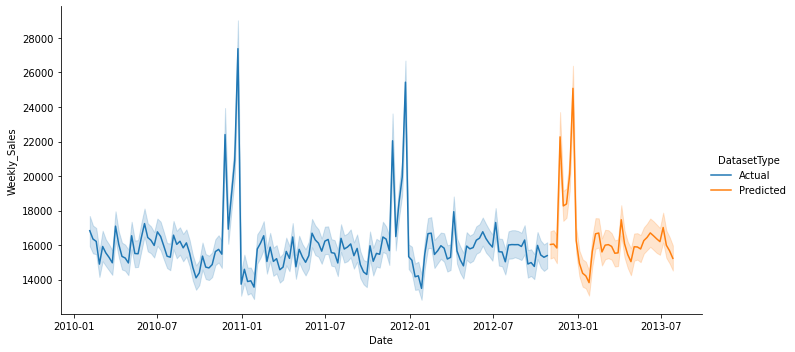

In [52]:
graph_relation_to_weekly_sale('DatasetType', df_result, x='Date')

In [59]:
sampleSubmission['Weekly_Sales'] = y_pred
sampleSubmission.to_csv('submission.csv',index=False)

We altered a bit the function below from the code of [Mariana Dehon](https://www.kaggle.com/marianadehon/walmart-store-sales-forecasting) on Kaggle.

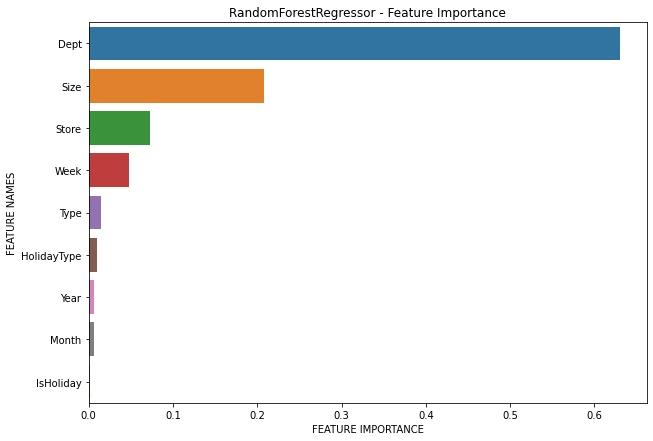

In [53]:
def plot_features_importance(importance, names, model_type):
    """
    This function plots the model features importance
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)


    data={'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10, 7))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(f'{model_type} - Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

features_importance = model.feature_importances_

plot_features_importance(
    features_importance,
    X_test.columns,
    best_model
)

In [55]:
weekly_sales_train = pd.Series(index=weekly_sales_2011.index.to_list())
for i in range(1, len(weekly_sales_2011)+1):
    count = 3
    sum_week = 0
    try:
        sum_week += weekly_sales_2010.loc[float(i)]
    except KeyError:
        count -= 1
    try:
        sum_week += weekly_sales_2012.loc[float(i)]
    except KeyError:
        count -= 1
    sum_week += weekly_sales_2011.loc[float(i)]

    mean = sum_week/count


    weekly_sales_train.loc[float(i)] = mean

C:\Users\Clara\AppData\Local\Temp/ipykernel_22756/3149853276.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weekly_sales_train = pd.Series(index=weekly_sales_2011.index.to_list())


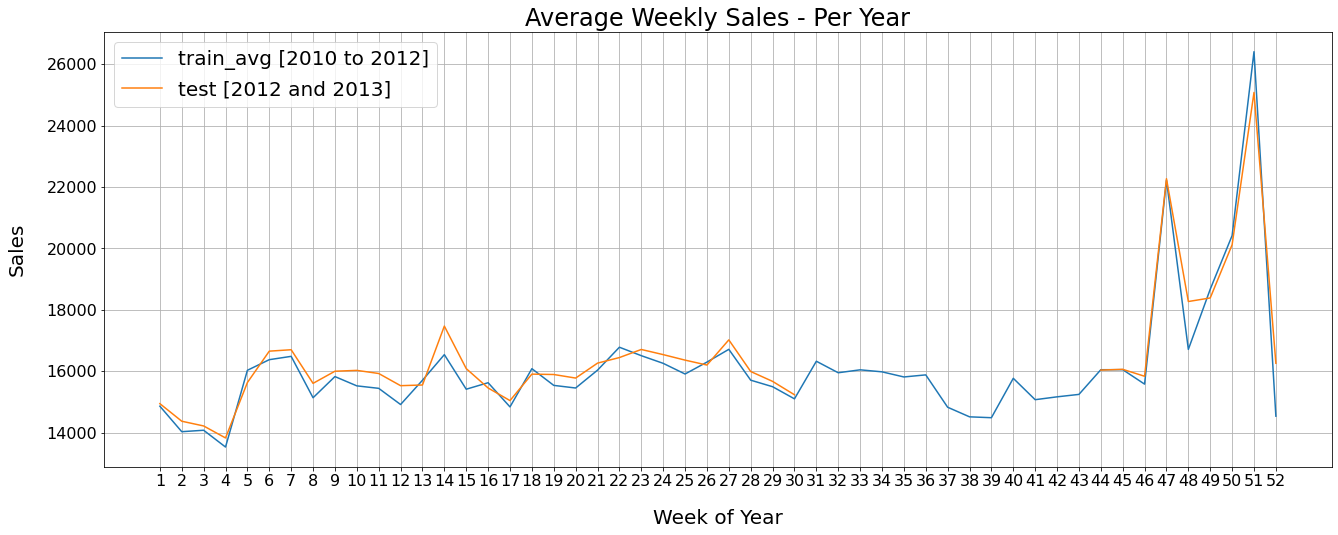

In [145]:

weekly_sales_2013 = df_test.groupby('Week')['Weekly_Sales'].mean()
weeks = np.linspace(1.0, 52.0, 52)
for w in weeks:
    if w not in weekly_sales_2013.index:
        weekly_sales_2013[w] = None
plt.figure(figsize=(22,8))
plt.plot(weekly_sales_train.index, weekly_sales_train.values)
plt.plot(weekly_sales_2013.sort_index().index, weekly_sales_2013.sort_index().values)

plt.grid()
plt.xticks(np.arange(1, 53, step=1), fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Week of Year', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20)

plt.title("Average Weekly Sales - Per Year", fontsize=24)
plt.legend(['train_avg [2010 to 2012]', 'test [2012 and 2013]'], fontsize=20)
plt.show()

# Are the dropped columns really not useful?

In [103]:
df_train_with_md = df_train_orig.copy()
df_test_with_md = df_test_orig.copy()
df_train_others = df_train_orig.copy()
df_test_others = df_test_orig.copy()


In [104]:
df_train_with_md.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1, inplace=True)
df_test_with_md.drop(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1, inplace=True)
df_train_others.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)
df_test_others.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

In [105]:
create_features(df_train_with_md)
create_features(df_test_with_md)
create_features(df_train_others)
create_features(df_test_others)

In [107]:
# ['Store', 'Dept', 'IsHoliday', 'Type', 'Size', 'HolidayType', 'Week', 'Year', 'Month']
X_train_with_md = df_train_with_md[['Store', 'Dept', 'IsHoliday', 'MarkDown1',
                    'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type', 'Size',
                    'HolidayType', 'Week', 'Year', 'Month']]
y_train_with_md = df_train_with_md['Weekly_Sales']

X_test_with_md = df_test_with_md[['Store', 'Dept', 'IsHoliday', 'MarkDown1',
                   'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Type', 'Size',
                   'HolidayType', 'Week', 'Year', 'Month']]

X_train_others = df_train_others[['Store', 'Dept', 'IsHoliday', 'Temperature',
                   'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size', 'HolidayType',
                   'Week', 'Year', 'Month']]
y_train_others = df_train_others['Weekly_Sales']

X_test_others = df_test_others[['Store', 'Dept', 'IsHoliday', 'Temperature',
                  'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size', 'HolidayType',
                  'Week', 'Year', 'Month']]


In [108]:
print(f'Best model is {best_model}')
print(f'Best params are {best_params}')

model = model_factory(
    best_model,
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    max_depth=best_params['min_samples_split'],
    verbose=1,
    njobs=-1)

model.fit(X_train_with_md, y_train_with_md)

Best model is RandomForestRegressor
Best params are {'n_estimators': 55, 'max_depth': 25, 'min_samples_split': 2}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.1min finished


RandomForestRegressor(n_estimators=55, verbose=1)

In [109]:
print(f'Best model is {best_model}')
print(f'Best params are {best_params}')

model_others = model_factory(
    best_model,
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    max_depth=best_params['min_samples_split'],
    verbose=1,
    njobs=-1)

model_others.fit(X_train_others, y_train_others)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model is RandomForestRegressor
Best params are {'n_estimators': 55, 'max_depth': 25, 'min_samples_split': 2}


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.4min finished


RandomForestRegressor(n_estimators=55, verbose=1)

In [110]:
y_pred_with_md = model.predict(X_test_with_md)
y_pred_others = model_others.predict(X_test_others)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.5s finished


In [111]:
df_test_with_md['Weekly_Sales'] = y_pred_with_md
df_test_with_md['DatasetType'] = 'Predicted'

df_train_with_md['DatasetType'] = 'Actual'

df_result_with_md = pd.concat([df_train_with_md, df_test_with_md]).reset_index(drop=True)
df_result_with_md

,Store,Dept,Date,Weekly_Sales,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Type,Size,HolidayType,Week,Year,Month,DatasetType
0,1.0,1.0,2010-02-05,24924.500000,False,0.00,0.00,0.00,0.00,0.00,3.0,151315.0,0.0,5.0,2010.0,2.0,Actual
1,1.0,1.0,2010-02-12,46039.490000,True,0.00,0.00,0.00,0.00,0.00,3.0,151315.0,1.0,6.0,2010.0,2.0,Actual
2,1.0,1.0,2010-02-19,41595.550000,False,0.00,0.00,0.00,0.00,0.00,3.0,151315.0,0.0,7.0,2010.0,2.0,Actual
3,1.0,1.0,2010-02-26,19403.540000,False,0.00,0.00,0.00,0.00,0.00,3.0,151315.0,0.0,8.0,2010.0,2.0,Actual
4,1.0,1.0,2010-03-05,21827.900000,False,0.00,0.00,0.00,0.00,0.00,3.0,151315.0,0.0,9.0,2010.0,3.0,Actual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536629,45.0,98.0,2013-06-28,702.736909,False,4842.29,975.03,3.00,2449.97,3169.69,2.0,118221.0,0.0,26.0,2013.0,6.0,Predicted
536630,45.0,98.0,2013-07-05,739.469273,False,9090.48,2268.58,582.74,5797.47,1514.93,2.0,118221.0,0.0,27.0,2013.0,7.0,Predicted
536631,45.0,98.0,2013-07-12,736.063091,False,3789.94,1827.31,85.72,744.84,2150.36,2.0,118221.0,0.0,28.0,2013.0,7.0,Predicted
536632,45.0,98.0,2013-07-19,757.658545,False,2961.49,1047.07,204.19,363.00,1059.46,2.0,118221.0,0.0,29.0,2013.0,7.0,Predicted


In [112]:
df_test_others['Weekly_Sales'] = y_pred_others
df_test_others['DatasetType'] = 'Predicted'

df_train_others['DatasetType'] = 'Actual'

df_result_others = pd.concat([df_train_others, df_test_others]).reset_index(drop=True)
df_result_others

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,HolidayType,Week,Year,Month,DatasetType
0,1.0,1.0,2010-02-05,24924.500000,False,42.31,2.572,211.096358,8.106,3.0,151315.0,0.0,5.0,2010.0,2.0,Actual
1,1.0,1.0,2010-02-12,46039.490000,True,38.51,2.548,211.242170,8.106,3.0,151315.0,1.0,6.0,2010.0,2.0,Actual
2,1.0,1.0,2010-02-19,41595.550000,False,39.93,2.514,211.289143,8.106,3.0,151315.0,0.0,7.0,2010.0,2.0,Actual
3,1.0,1.0,2010-02-26,19403.540000,False,46.63,2.561,211.319643,8.106,3.0,151315.0,0.0,8.0,2010.0,2.0,Actual
4,1.0,1.0,2010-03-05,21827.900000,False,46.50,2.625,211.350143,8.106,3.0,151315.0,0.0,9.0,2010.0,3.0,Actual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536629,45.0,98.0,2013-06-28,266.671091,False,76.05,3.639,0.000000,0.000,2.0,118221.0,0.0,26.0,2013.0,6.0,Predicted
536630,45.0,98.0,2013-07-05,253.449091,False,77.50,3.614,0.000000,0.000,2.0,118221.0,0.0,27.0,2013.0,7.0,Predicted
536631,45.0,98.0,2013-07-12,256.413091,False,79.37,3.614,0.000000,0.000,2.0,118221.0,0.0,28.0,2013.0,7.0,Predicted
536632,45.0,98.0,2013-07-19,250.184727,False,82.84,3.737,0.000000,0.000,2.0,118221.0,0.0,29.0,2013.0,7.0,Predicted


In [115]:
sampleSubmission['Weekly_Sales'] = y_pred_with_md
sampleSubmission.to_csv('submission_with_md.csv',index=False)

In [118]:
sampleSubmission['Weekly_Sales'] = y_pred_others
sampleSubmission.to_csv('submission_others.csv',index=False)